# Addressing Class Imbalance: SMOTE and ADSYSN

In this notebook, we will apply techniques that we can use to address class imbalance and observe the impact of such techniques to the prediction performance of our machine learning models. Specifically, we will:

* Get acquainted with the intuition behind the (1) basic techniques (e.g., random upsampling/downsampling, synthetic data generation) and (2) the use of other metrics that are more suitable to imbalanced ml problems.
* Compare and contrast among these basic techniques
* Briefly go through more elaborate techniques to address class imbalance

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
df = pd.read_csv('covid_clinical.csv')
df.head(3)


,pid,var1,var2,var3,class
0,0,-0.294129,-1.770098,2.331246,0
1,1,0.492923,-0.528002,1.173842,0
2,2,0.430697,0.053801,0.322743,0


In [12]:
# plot for visuals on impace of resampling techniques
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt

def plot_3vars(feature_frame, target_array, feature_names, title):
    sns.set_style("whitegrid", {'axes.grid' : True})
    fig = plt.figure(figsize=(20,5))
    
    alpha = 0.4
    
    # for the 3D plot
    ax1 = fig.add_subplot(141, projection='3d')
    ax1.scatter(xs=feature_frame[feature_names[0]], 
                ys=feature_frame[feature_names[1]],
                zs=feature_frame[feature_names[2]], 
                c=target_array, # class determines color 
                marker='o', cmap='viridis', alpha=alpha)
    ax1.set_xlabel(feature_names[0])
    ax1.set_ylabel(feature_names[1])
    ax1.set_zlabel(feature_names[2])
    ax1.view_init(10, 30)
    
    # for the 2D plots
    sns.set_style("darkgrid", {'axes.grid' : True})
    for index, combi in enumerate(combinations(feature_names, 2)):
        ax = fig.add_subplot(140 + index + 2)
        ax.scatter(x=feature_frame[combi[0]], 
                   y=feature_frame[combi[1]], 
                   c=target_array, 
                   marker='o', cmap='viridis', alpha=alpha)
        ax.set_xlabel(combi[0], fontsize=12)
        ax.set_ylabel(combi[1], fontsize=12)
    fig.suptitle(title, size=15)
    return None

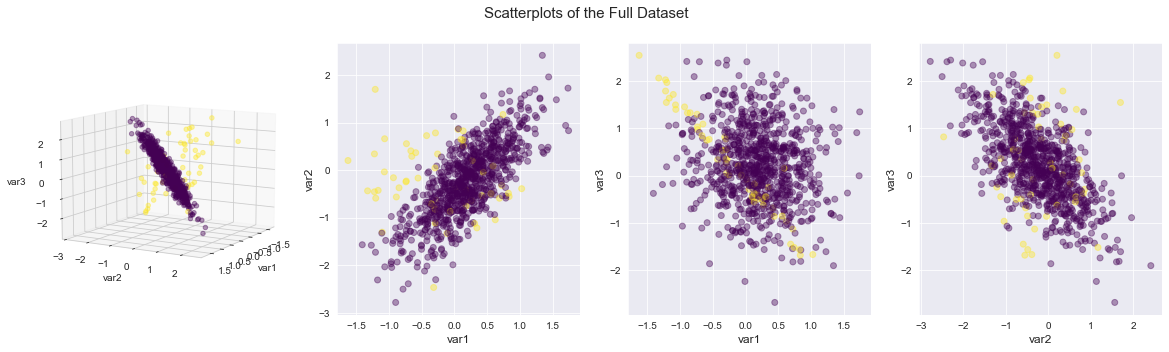

In [13]:
X, y = df.drop(columns=['pid', 'class']), df['class']

plot_3vars(feature_frame=X, target_array=y, feature_names=['var1', 'var2', 'var3'], 
           title='Scatterplots of the Full Dataset')

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=11)

## Random Undersampling

**Description:** Randomly choosing samples from the **majority** class to **remove** from the training data.

In [15]:
# insert undersampling code here
def random_undersample(feature_frame, target_array, random_state=11):
    """Return data with undersampled minority class to balance the data"""
    
    dataset = feature_frame.copy()
    dataset['target'] = y
    minority_class = dataset['target'].value_counts().argmin()
    
    # number of samples to retain from majority class, minority class count
    n = int(dataset['target'].value_counts().min())
    
    # rows to retain from majority
    retain_rows = (dataset[dataset['target'] != minority_class]
                   .sample(n=n, random_state=random_state, replace=True))
    
    # minority class rows and sampled majority class rows
    dataset = dataset[dataset['target']==minority_class].append(retain_rows)
    
    X_resampled = dataset.drop(columns='target') 
    y_resampled = dataset['target']
    
    return X_resampled, y_resampled

In [16]:
# perform random undersampling
(X_train_undersampled, 
 y_train_undersampled) = random_undersample(X_train, y_train, random_state=11)

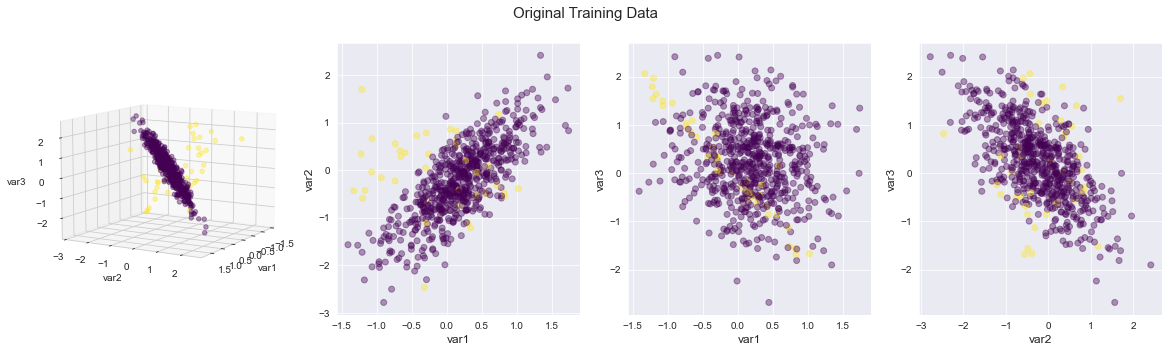

In [17]:
plot_3vars(feature_frame=X_train, target_array=y_train,
           feature_names=['var1', 'var2', 'var3'], 
            title='Original Training Data')

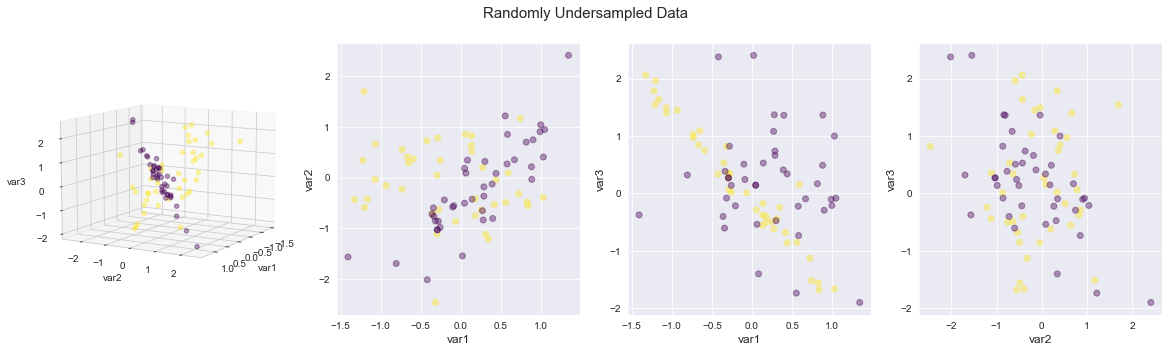

In [18]:
plot_3vars(feature_frame=X_train_undersampled, 
           target_array=y_train_undersampled,
           feature_names=['var1', 'var2', 'var3'],
           title='Randomly Undersampled Data')

In [19]:
# y_train_undersampled.value_counts().plot.bar();

**Advantages and Disadvantages**

* (+) Balances the data, reducing the learning bias towards the majority class
* (-) Significantly reduces the training data resulting to *loss in information*. Additionally, we may find that our training set becomes smaller than our test set.

## Random Oversampling

**Description:** Randomly choosing samples from the **minority** class to **add back** to the training data.

In [20]:
# insert oversampling code here
def random_oversample(feature_frame, target_array, random_state=11):
    """Return data with oversampled minority class to balance the data"""
    
    dataset = feature_frame.copy()
    dataset['target'] = y
    minority_class = dataset['target'].value_counts().argmin()
    
    # number of samples to generate
    n = int(dataset['target'].value_counts().diff().abs().sum() )
    
    new_rows = (dataset[dataset['target']==minority_class]
                .sample(n=n, random_state=random_state, replace=True))
    
    dataset = dataset.append(new_rows)
    
    X_resampled = dataset.drop(columns='target') 
    y_resampled = dataset['target']
    
    return X_resampled, y_resampled

In [21]:
# perform random oversampling
(X_train_oversampled, 
 y_train_oversampled) = random_oversample(X_train, y_train, random_state=11)

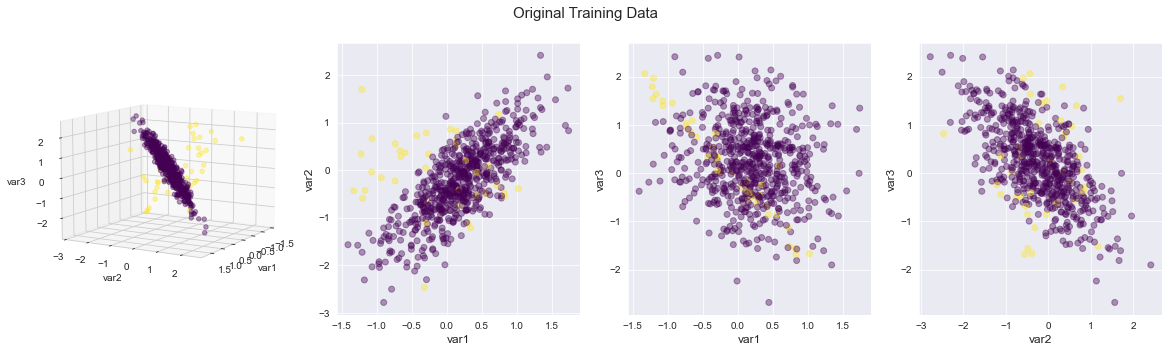

In [22]:
plot_3vars(feature_frame=X_train, target_array=y_train,
           feature_names=['var1', 'var2', 'var3'], 
            title='Original Training Data')

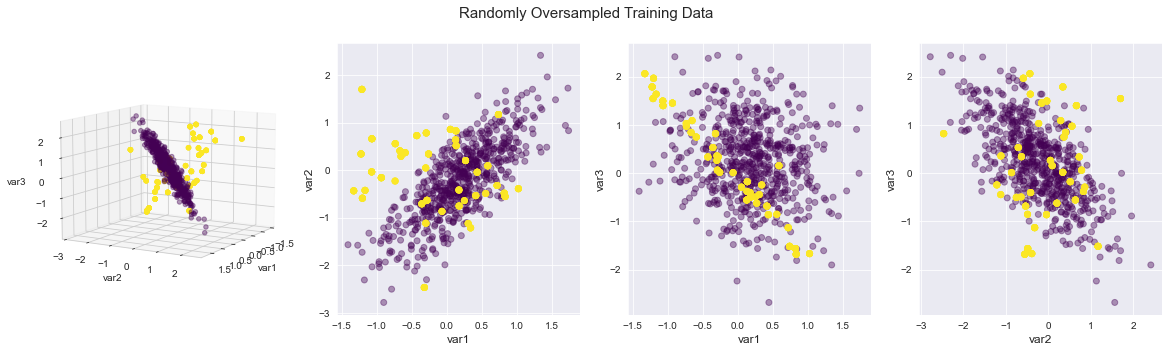

In [23]:
plot_3vars(feature_frame=X_train_oversampled, 
           target_array=y_train_oversampled,
           feature_names=['var1', 'var2', 'var3'],
           title='Randomly Oversampled Training Data')

In [24]:
# y_train_oversampled.value_counts().plot.bar();

**Advantages and Disadvantages**

* (+) Bias towards majority cass is alleviated by the random repetition of minority class examples.
* (-) May increase the likelihood of overfitting because of the repetition (notable for higher sampling rates).
* (-) Increased computational effort

## SMOTE: Synthetic Minority Oversampling Technique

**Description:** An over-sampling aproach that creates "synthetic" examples using the points between two neighboring minority samples--through interpolation.

<img src='smote_adasyn_algo.PNG' width='500'>

**Algorithm:**

1. Initialize the $\beta$ value, which is the resulting ratio of the minority and majority class after resampling. $\beta = 1$ for perfect balance (50-50).
2. Intialize the number of neighboring minority class to consider when creating synthetic data.
3. Calculate the number of samples to generate `new_samples_count`
4. Randomly select a minority class representative with replacement `new_samples_count` times.
5. For each minority class reference sample, perform the following algorithm:
    * Randomly select a neighbor
    * Generate synthetic data using the formula: $s = x + (x_z - x) * \lambda$ where $s$ is the synthetic data, $x$ reference sample (of interest), $xz$ neighboring minority class sample, and $\lambda$ as a random weighting factor to the element-wise difference $(x_z - x)$.
    * Loop through each randomly selected minority class sample, while collecting the new synthetic data at each time.
6. Add the synthetic data to the training data used as input, `feature_frame`.

In [ ]:
from sklearn.neighbors import NearestNeighbors
def smote(feature_frame, target_array, beta=1, n_neighbors=5, random_state=42):
    """Return resampled X, y data from SMOTE method"""
    
    # initialize random seed for reproducibility
    np.random.seed(random_state)
    
    feature_frame = feature_frame.reset_index(drop=True)
    target_array = target_array.reset_index(drop=True)

    m_l = target_array.value_counts().max()
    m_s = target_array.value_counts().min()

    # label of minority class
    minority_label = target_array.value_counts().argmin()

    # get index of minority samples
    minority_indices = list(target_array[(target_array==minority_label)].index)
    minority_frame = feature_frame.iloc[minority_indices]

    # get minority neighbors of minority samples, n_neighbors inlcudes self (hence '+1')
    neighbors = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(minority_frame)
    _, nbrs_indices = neighbors.kneighbors(minority_frame)

    # count number of samples to meet preferred class ratio
    new_samples_count = (beta * m_l) - m_s

    # generate random indices, random selection of reference samples
    index_list = np.random.randint(0, minority_frame.shape[0], 
                                   size=new_samples_count)

    synth_samples = []
    for ref_index in index_list:
        other_index = np.random.choice(nbrs_indices[ref_index, 1:])
        x = minority_frame.iloc[ref_index].to_numpy().reshape(1, -1)
        xz = minority_frame.iloc[other_index].to_numpy().reshape(1, -1)

        # generate synthetic data
        synth_sample = x + (xz - x) * np.random.uniform(0, 1)
        synth_samples.append(synth_sample[0])

    # transform new samples into a dataframe
    synth_df = pd.DataFrame(np.array(synth_samples), 
                            columns=feature_frame.columns)
    # target col, all from minority class
    synth_df['target'] = [minority_label for i in range(synth_df.shape[0])] 

    # prepare outputs
    dataset = feature_frame.reset_index(drop=True)
    dataset['target'] = target_array.reset_index(drop=True)
    dataset = dataset.append(synth_df)
    X_resampled = dataset.drop(columns='target')
    y_resampled = dataset['target']   
    return X_resampled, y_resampled

In [ ]:
(X_train_smote, 
 y_train_smote) = smote(X_train, y_train, random_state=11)

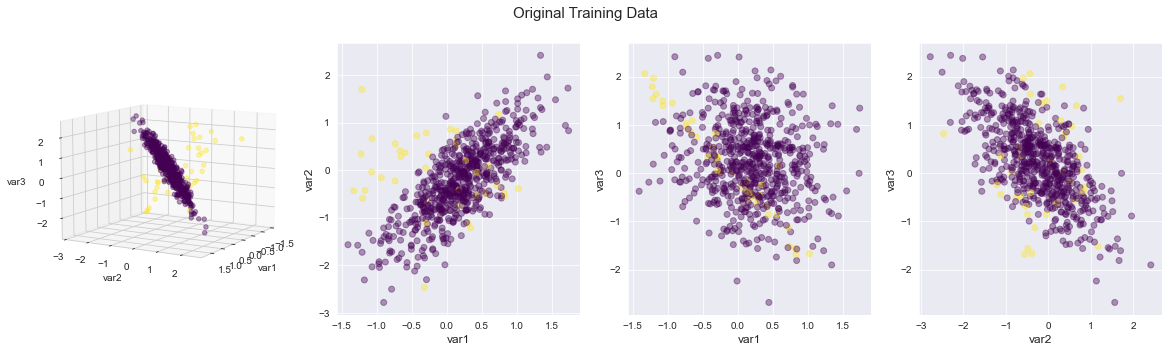

In [ ]:
# original training data
plot_3vars(feature_frame=X_train, target_array=y_train,
           feature_names=['var1', 'var2', 'var3'], 
           title='Original Training Data')

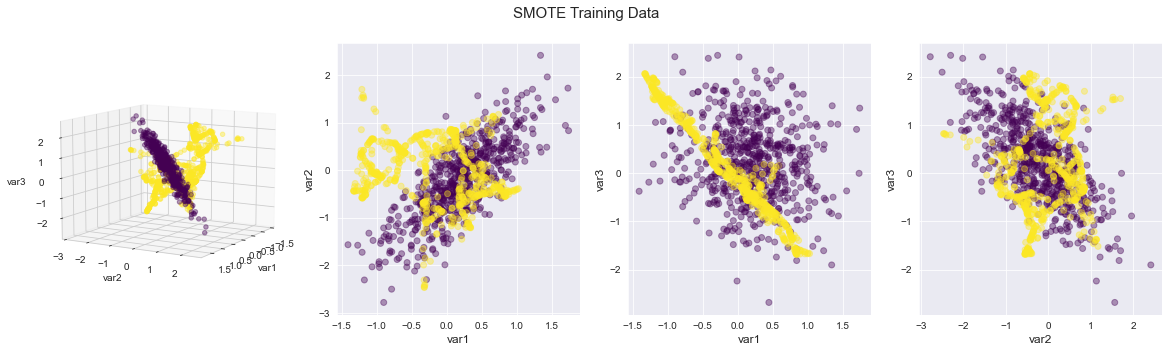

In [ ]:
plot_3vars(feature_frame=X_train_smote, 
           target_array=y_train_smote,
           feature_names=['var1', 'var2', 'var3'],
           title='SMOTE Training Data')

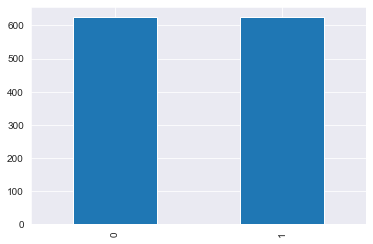

In [ ]:
y_train_smote.value_counts().plot.bar();

**Advantages and Disadvantages**

* (+) Addresses the likely overfitting due to sample repetition done during random oversampling.
* (-) Does not discriminate between outlier and inlier minority class examples
* (-) Might connect outliers with inliers through the interpolation algorithm it employs



*Alternatively, you may refer to `imblearn`'s implementation of* [SMOTE.](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)

## ADASYN: Adaptive Synthetic Sampling Method

Personal notes: **More data is generated on "harder to learn" minority points** https://medium.com/@ruinian/an-introduction-to-adasyn-with-code-1383a5ece7aa

**Description:** Similar to SMOTE, ADASYN creates "synthetic" examples using the points between two neighboring minority samples. ADASYN however employs a weighted distribution of the minority class examples according to level of difficulty of learning. This weighted distribution is determined by the number of majority classes in the $K$ neighborhood of a minority sample.

**Algorithm:**

1. Caculate `d`: $d = m_s / m_l$ where $m_s$ and $m_l$ are the number of samples in the minority and majority class respectively.
2. Check if class ratio `d` is below the acceptable threshold `d_tresh`. If yes, proceed with the next steps.
3. Determine the number of samples `G` to add using: $G = (m_l - m_s) * \beta$, where $\beta$ is the preferred class ratio after resampling. $\beta = 1$ means a perfect balance.
4. Get the nearest `n_neighbors` of each minority class sample.
5. Get the ratio $r_i$ of $m_l$ and `n_neighbors` ($K$) for each minority class sample neighborhood. $r_i = m_l / K$
6. Normalize the $r_i$ to obtain a density distribution.
7. Use the density distribution to get the number of synthetic samples $g$ to be generated per minority class. $g = r_i * G$ 
8. Generate $g$ samples per original minority class sample using the following algorithm:
    * Select a random minority class sample within the neighborhood of the sample of interest
    * Generate synthetic data using the formula: $s = x + (x_z - x) * \lambda$ where $s$ is the synthetic data, $x$ reference sample (of interest), $xz$ neighboring minority class sample, and $\lambda$ as a random weighting factor to the element-wise difference $(x_z - x)$. *Similar algorithm with SMOTE*
    * Repeat $g$ times for each minority class sample, collecting the new synthetic data at each time.
9. Add the synthetic data to the training data used as input, `feature_frame`.

In [ ]:
from sklearn.neighbors import NearestNeighbors


def adasyn(feature_frame, target_array, d_tresh, beta, n_neighbors, 
           random_state=11):
    """Return resampled X, y data from ADASYN method"""
    
    # initialize random seed for reproducibility
    np.random.seed(random_state)
    
    m_l = target_array.value_counts().max()
    m_s = target_array.value_counts().min()
    
    d =  m_s / m_l 
    
    # d_tresh is the maximum allowed class ratio before resampling triggers
    if not (d < d_tresh):
        return None
    
    # number of samples to add, controlled by beta
    G = (m_l - m_s) * beta

    # label of minority class
    minority_label = target_array.value_counts().argmin()
    
    # get neighbors of all samples, n_neighbors inlcudes self (hence '+1')
    neighbors = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(feature_frame)
    _, nbrs_indices = neighbors.kneighbors(feature_frame)

    target_array = target_array.reset_index(drop=True)
    minority_indices = list(target_array[(target_array==minority_label)].index)
    minority_nbrs = nbrs_indices[minority_indices, 1:]


    r_array = [] # array of ratios, (number of m_l / n_neighbors)
    for nbrs in minority_nbrs:

        # n_neighbors minus minority count
        delta = n_neighbors - (target_array[nbrs]==minority_label).sum()
        r = delta / n_neighbors
        r_array.append(r)

    # normalize r_array, r_density_dist sums to 1
    r_density_dist = r_array / np.sum(r_array)

    # count of synthetic samples to be generated per minority sample
    gs = np.round(np.array(r_density_dist) * G)

    synth_samples = []
    for index, minority_index in enumerate(minority_indices):
        # reshape the m_s sample of interest
        x = feature_frame.iloc[minority_index].to_numpy().reshape(1, -1)
        nbrs = minority_nbrs[index]

        x_nbr = [i for i in nbrs if i in minority_indices]

        if len(x_nbr):
            for i in range(int(gs[index])):
                # choose one random neighbor that is also m_s
                xz = (feature_frame.iloc[np.random.choice(x_nbr)]
                                    .to_numpy()
                                    .reshape(1, -1))

                synth_sample = x + (xz - x) * np.random.uniform(0, 1)
                synth_samples.append(synth_sample[0])

        # if no nbr from minority, skip generating synth samples
        else: 
            continue

    # transform new samples into a dataframe
    synth_df = pd.DataFrame(np.array(synth_samples), 
                            columns=feature_frame.columns)
    # target col, all from minority class
    synth_df['target'] = [minority_label for i in range(synth_df.shape[0])] 
    
    # prepare outputs
    dataset = feature_frame.reset_index(drop=True)
    dataset['target'] = target_array.reset_index(drop=True)
    dataset = dataset.append(synth_df)
    X_resampled = dataset.drop(columns='target')
    y_resampled = dataset['target']    
    
    return X_resampled, y_resampled

In [ ]:
(X_train_adasyn, 
 y_train_adasyn) = adasyn(X_train, y_train, d_tresh=0.3, beta=1, n_neighbors=5, 
                          random_state=11)

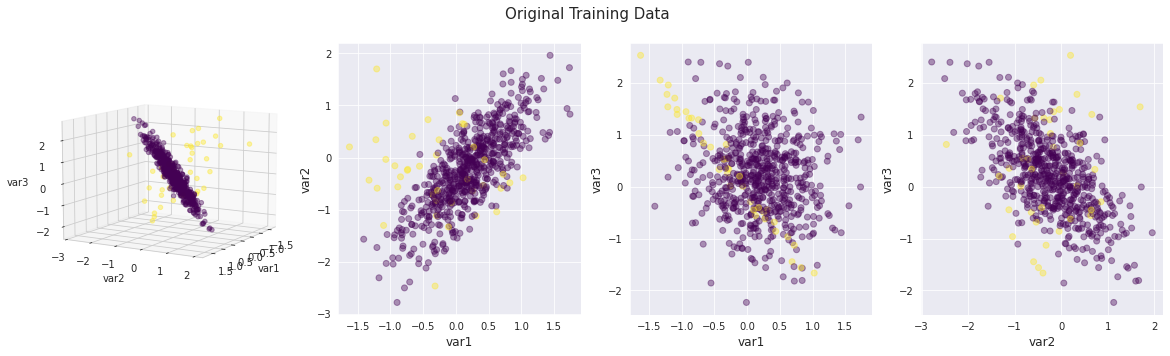

In [23]:
# original training data
plot_3vars(feature_frame=X_train, target_array=y_train,
           feature_names=['var1', 'var2', 'var3'], 
           title='Original Training Data')

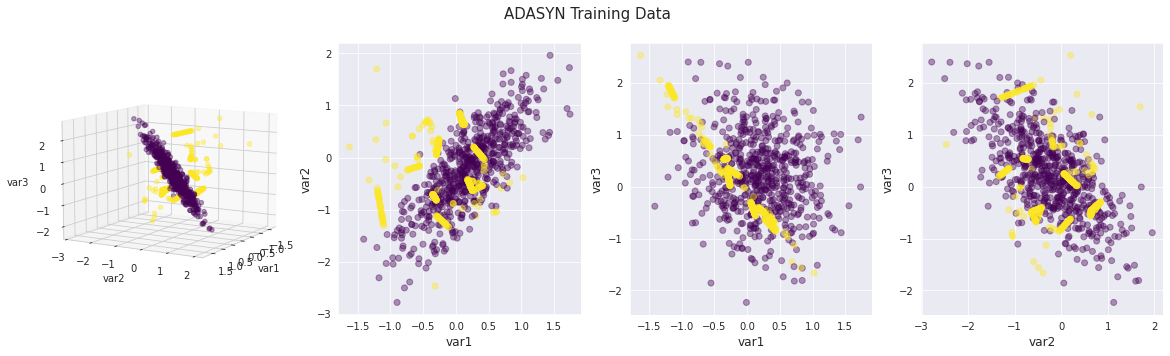

In [24]:
plot_3vars(feature_frame=X_train_adasyn, 
           target_array=y_train_adasyn,
           feature_names=['var1', 'var2', 'var3'],
           title='ADASYN Training Data')

In [25]:
# y_train_adasyn.value_counts().plot.bar();

**Advantages and Disadvantages**

* (+) Reduces bias caused by the class imbalance
* (+) An adaptive shifting of the classification boundary toward the more "difficult" examples.
* (-) May focus solely on the outliers


*Alternatively, you may refer to `imblearn`'s implementation of* [ADASYN.](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.ADASYN.html)

## Other Techniques

The following presents other techniques that either presents an entirely new approach from what we discussed or some modifications to suit other scenarios (e.g., categorical features in the data, improvements to SMOTE/ADASYN). As there is quite a host of studies relating to class imbalance, this list is not exhaustive and is based primarily on some implementations available at `imblearn`. *Note: Description column is delibrately left out for your exercise.*

|Name|Source|Description|
|--|--|--|
|[BorderlineSMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.BorderlineSMOTE.html)|[Han, et al (2005)](https://doi.org/10.1007/11538059_91)|xxx|
|[SVMSMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SVMSMOTE.html)|[Nguyen et al (2009)](https://ousar.lib.okayama-u.ac.jp/files/public/1/19617/20160528004522391723/IWCIA2009_A1005.pdf)|xxx|
|[KMeansSMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.KMeansSMOTE.html)|[Last, et al (2017)](https://doi.org/10.1016/j.ins.2018.06.056)|xxx|
|[SMOTENC](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html)|[Chawla, et al (2002)](https://doi.org/10.1613/jair.953)|xxx|
|[SMOTEN](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTEN.html)|[Chawla, et al (2002)](https://doi.org/10.1613/jair.953)|xxx|
|[NearMiss](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.NearMiss.html)|[Mani & Zhang (2003)](https://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf)|xxx|
|[TomekLinks](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.TomekLinks.html)|[Tomek (1976)](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=4309523)|xxx|
|[EditedNearestNeighbours](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.EditedNearestNeighbours.html)|[Wilson 1972](https://sci2s.ugr.es/keel/dataset/includes/catImbFiles/1972-Wilson-IEEETSMC.pdf)|xxx|
|[RepeatedEditedNearestNeighbors](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RepeatedEditedNearestNeighbours.html)|[Tomek (1976)](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=4309523)|xxx|
|[AllKNN](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.AllKNN.html)|[Tomek (1976)](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=4309523)|xxx|
|[SMOTETomek](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html)|[Batista, et al (2004)](https://doi.org/10.1145/1007730.1007735)|xxx|
|[SMOTEENN](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTEENN.html)|[Batista, et al (2003)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.10.2192&rep=rep1&type=pdf)|xxx|


### References

* `imblearn` [User Guide](https://imbalanced-learn.org/stable/user_guide.html)
* Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002). SMOTE: synthetic minority over-sampling technique. Journal of artificial intelligence research, 16, 321-357.
* He, H., Bai, Y., Garcia, E. A., & Li, S. (2008, June). ADASYN: Adaptive synthetic sampling approach for imbalanced learning. In 2008 IEEE international joint conference on neural networks (IEEE world congress on computational intelligence) (pp. 1322-1328). IEEE.
* Géron, A. (2019). Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: Concepts, tools, and techniques to build intelligent systems. O'Reilly Media.
* James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning (Vol. 112, p. 18). New York: springer.

# End